In [1]:
import pandas as pd
from biom import load_table
from skbio import OrdinationResults, DistanceMatrix
import glob
import numpy as np
import matplotlib 
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

%matplotlib inline

In [2]:
# import results
metadata = pd.read_csv('../../data/case-studies/mammalian/matched-data/metadata.tsv', index_col=0, sep='\t')
metadata['lineage_and_digestive_strategy'] = metadata['KT_lineage'] + '-' + metadata['digestive_strategy']
tables = {f.split('/')[-1].split('.')[0]:load_table(f) for f in glob.glob('../../data/case-studies/mammalian/matched-data/*.biom')}
joint_ords = {f.split('/')[-1].split('-')[0]:OrdinationResults.read(f) 
              for f in glob.glob('../../data/case-studies/mammalian/joint-rpca/*-ordination.txt')}
joint_dists = {f.split('/')[-1].split('-')[0]:DistanceMatrix.read(f) 
              for f in glob.glob('../../data/case-studies/mammalian/joint-rpca/*-distance.txt')}
ordination_ind = {tuple(f.split('/')[-1].split('-')[:2]):OrdinationResults.read(f)
                  for f in glob.glob('../../data/case-studies/mammalian/rpca-independent/*-ordination.txt')}
distance_ind = {tuple(f.split('/')[-1].split('-')[:2]):DistanceMatrix.read(f)
                for f in glob.glob('../../data/case-studies/mammalian/rpca-independent/*-distance.txt')}


In [3]:
feature_selection_methods = ['all features','Joint-RPCA','RPCA']
color_list = [(k1, k2) for k1 in tables.keys() for k2 in feature_selection_methods]
colors_tmp = cm.Paired(np.linspace(0, 1, len(color_list)))
color_map = {l:c for l, c in zip(color_list, colors_tmp)}
perc_use = 0.05 #0.15
scores_tmp_all = {}
roc_tmp = {}
pr_tmp = {}
all_feats_saved = {}

for fold in range(10):

    # get ys' to predict
    metadata_train = metadata[metadata['traintest_%i' % (fold)] == 'train']
    metadata_test = metadata[metadata['traintest_%i' % (fold)] == 'test']
    y_train = list(metadata_train['lineage_and_digestive_strategy'].values)
    n_classes = len(set(y_train))
    covert_map = {v:i for i, v in enumerate(set(y_train))}
    y_train = [covert_map[i] for i in y_train]
    y_train = label_binarize(y_train, classes=list(covert_map.values()))
    y_test = list(metadata_test['lineage_and_digestive_strategy'].values)
    y_test = [covert_map[i] for i in y_test]
    y_test = label_binarize(y_test, classes=list(covert_map.values()))

    for dt_name, bt_tbl in tables.items():
        for fs_ in feature_selection_methods:

            tbl = pd.DataFrame(bt_tbl.matrix_data.toarray(),
                               bt_tbl.ids('observation'),
                               bt_tbl.ids()).T
            n_top_joint_rpca = int(len(tbl.columns) * perc_use) // 3

            if fs_  == 'Joint-RPCA':
                ord_tmp_fold_joint = joint_ords[str(fold)].features.copy()
                ord_tmp_fold_joint = ord_tmp_fold_joint.loc[[x for x in ord_tmp_fold_joint.index
                                                             if dt_name in x], :]
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_joint.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])
                all_feats_saved[(n_top_joint_rpca, fold, dt_name)] = use_feats
                
            elif fs_  == 'RPCA':
                ord_tmp_fold_ind = ordination_ind[(dt_name, str(fold))].features.copy()
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_ind.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])
            
            else:
                use_feats = tbl.columns

            if (dt_name, fs_) not in scores_tmp_all.keys():
                scores_tmp_all[(dt_name, fs_)] = []
                pr_tmp[(dt_name, fs_)] = []
                roc_tmp[(dt_name, fs_)] = []

            X_train = tbl.loc[metadata_train.index, use_feats].values
            X_test = tbl.loc[metadata_test.index, use_feats].values

            classifier = OneVsRestClassifier(
                RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)
            )
            classifier.fit(X_train, y_train)


            y_score = classifier.predict_proba(X_test)

            # For each class
            precision = dict()
            recall = dict()
            average_precision = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
                average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
            #print(np.std(average_precision.values()))
            std_all = np.std(list(average_precision.values()))
            # A "micro-average": quantifying score on all classes jointly
            precision["micro"], recall["micro"], _ = precision_recall_curve(
                y_test.ravel(), y_score.ravel()
            )
            average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
            scores_tmp_all[(dt_name, fs_)].append(average_precision["micro"])
            roc_tmp[(dt_name, fs_)].append(roc_auc_score(y_test, y_score, average="micro"))
            pr_tmp[(dt_name, fs_)].append([y_test.ravel(), y_score.ravel()]) 

In [4]:
perc_use = 0.05 

for fs_ in ['RPCA-aggregated', 'Joint-RPCA-aggregated']:
    #add placeholders
    scores_tmp_all[('all',fs_)] = []
    pr_tmp[('all',fs_)] = []
    roc_tmp[('all',fs_)] = []

    for fold in range(10):

        # get ys' to predict
        metadata_train = metadata[metadata['traintest_%i' % (fold)] == 'train']
        metadata_test = metadata[metadata['traintest_%i' % (fold)] == 'test']
        y_train = list(metadata_train['lineage_and_digestive_strategy'].values)
        n_classes = len(set(y_train))
        covert_map = {v:i for i, v in enumerate(set(y_train))}
        y_train = [covert_map[i] for i in y_train]
        y_train = label_binarize(y_train, classes=list(covert_map.values()))
        y_test = list(metadata_test['lineage_and_digestive_strategy'].values)
        y_test = [covert_map[i] for i in y_test]
        y_test = label_binarize(y_test, classes=list(covert_map.values()))

        X_train_all = pd.DataFrame()
        X_test_all = pd.DataFrame()

        for dt_name, bt_tbl in tables.items():

            tbl = pd.DataFrame(bt_tbl.matrix_data.toarray(),
                                bt_tbl.ids('observation'),
                                bt_tbl.ids()).T
            n_top_joint_rpca = int(len(tbl.columns) * perc_use) // 3
            
            if fs_  == 'Joint-RPCA-aggregated':
                ord_tmp_fold_joint = joint_ords[str(fold)].features.copy()
                ord_tmp_fold_joint = ord_tmp_fold_joint.loc[[x for x in ord_tmp_fold_joint.index
                                                             if dt_name in x], :]
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_joint.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])
                all_feats_saved[(n_top_joint_rpca, fold, dt_name)] = use_feats
                
            elif fs_  == 'RPCA-aggregated':
                ord_tmp_fold_ind = ordination_ind[(dt_name, str(fold))].features.copy()
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_ind.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])

            X_train = tbl.loc[metadata_train.index, use_feats]
            X_test = tbl.loc[metadata_test.index, use_feats]

            #append to x_train_all and x_test_all
            X_train_all = pd.concat([X_train_all, X_train], axis=1)
            X_test_all = pd.concat([X_test_all, X_test], axis=1)

        classifier = OneVsRestClassifier(
            RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)
        )
        classifier.fit(X_train_all, y_train)
        y_score = classifier.predict_proba(X_test_all)

        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        #print(np.std(average_precision.values()))
        std_all = np.std(list(average_precision.values()))
        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_test.ravel(), y_score.ravel()
        )
        average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
        scores_tmp_all[('all',fs_)].append(average_precision["micro"])
        roc_tmp[('all',fs_)].append(roc_auc_score(y_test, y_score, average="micro"))
        pr_tmp[('all',fs_)].append([y_test.ravel(), y_score.ravel()])

In [5]:
color_map_short = {
    ('gcms', 'Joint-RPCA'):'#0571b0',
    ('all', 'RPCA-aggregated'):'#f4a582',
    ('all', 'Joint-RPCA-aggregated'):'lightsteelblue',
    ('gcms', 'RPCA'):'#ca0020',
    ('microbiome', 'Joint-RPCA'):'#0571b0',
    ('microbiome', 'RPCA'):'#ca0020'}

label_ = {'gcms':'Metabolomics (GCMS)', 
         'lipid_neg':'Lipidomics (-)', 
         'lipid_polar':'Metabolomics (semi-polar)', 
         'lipid_pos':'Lipidomics (+)' ,
         'microbiome':'Microbiome (16S)',
         'all':'All omics'}

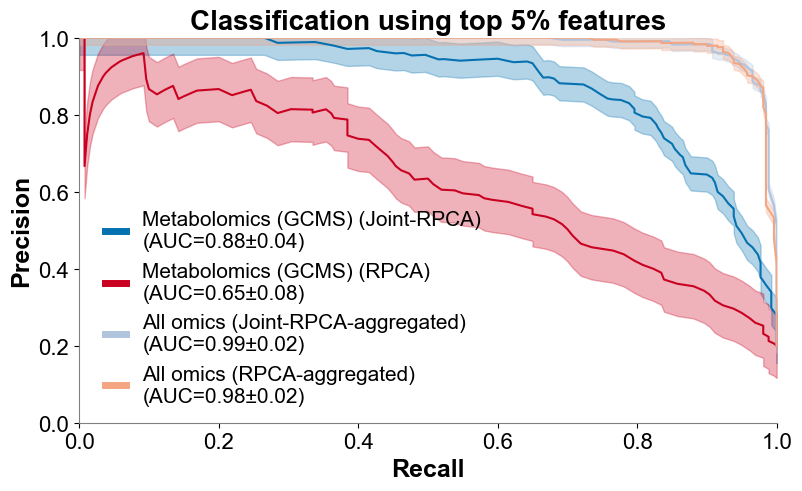

In [15]:
pairs = [('gcms', 'Joint-RPCA'), ('gcms', 'RPCA'), 
         ('all', 'Joint-RPCA-aggregated'),('all', 'RPCA-aggregated')]

fig, ax = plt.subplots(1,1,figsize=(9, 5))
for pair in pairs:
    y_real = np.concatenate([i[0] for i in pr_tmp[pair]])
    y_proba = np.concatenate([i[1] for i in pr_tmp[pair]])
    precision_avg, recall_avg, _ = precision_recall_curve(y_real, y_proba)
    ax.plot(recall_avg, precision_avg, c=color_map_short[pair],
            label='%s (%s)\n(AUC=%0.2f±%0.2f)' % (label_[pair[0]], pair[1],
                                                np.mean(scores_tmp_all[pair]),
                                                np.std(scores_tmp_all[pair])))
    ax.fill_between(recall_avg, precision_avg - np.std(scores_tmp_all[pair]),
                    precision_avg + np.std(scores_tmp_all[pair]),
                    alpha=0.3, color=color_map_short[pair])  

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall', color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_ylabel('Precision', color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_title('Classification using top 5% features', 
             color='black', weight='bold', 
             fontsize=20, fontname='Arial')
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(16)
legend = ax.legend(loc=2, 
        bbox_to_anchor=(.01, .6),
        prop={'size':15, 'family':'Arial'},
        title="", fancybox=True, framealpha=.0,
        ncol=1, markerscale=1, handlelength=1)

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(5.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(5.0)

plt.savefig('../../results/figure-5E.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-5E.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

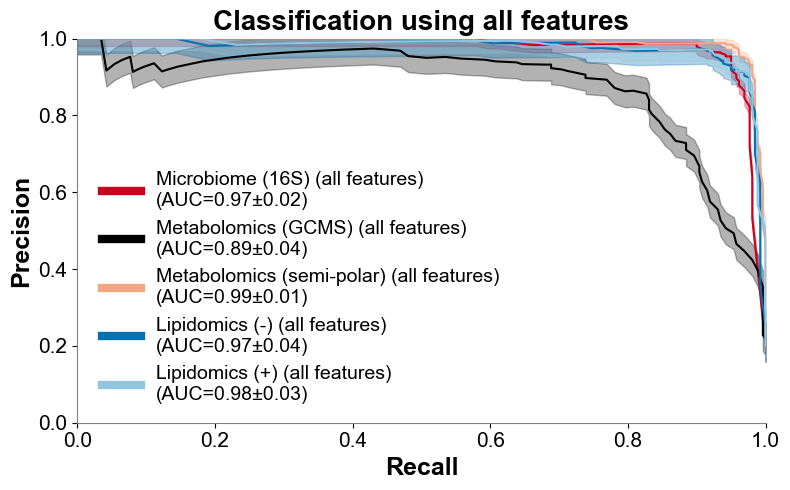

In [8]:
color_map = {('microbiome', 'all features'):'#ca0020',
             ('gcms', 'all features'):'black',
             ('lipid_polar', 'all features'):'#f4a582',
             ('lipid_neg', 'all features'):'#0571b0',
             ('lipid_pos', 'all features'):'#92c5de'}

pairs = [('microbiome', 'all features'), ('gcms', 'all features'),
        ('lipid_polar', 'all features'), ('lipid_neg', 'all features'), 
        ('lipid_pos', 'all features')]

fig, ax = plt.subplots(1,1,figsize=(8, 5))
for pair in pairs:
    y_real = np.concatenate([i[0] for i in pr_tmp[pair]])
    y_proba = np.concatenate([i[1] for i in pr_tmp[pair]])
    precision_avg, recall_avg, _ = precision_recall_curve(y_real, y_proba)
    ax.plot(recall_avg, precision_avg, c=color_map[pair],
            label='%s (%s)\n(AUC=%0.2f±%0.2f)' % (label_[pair[0]], pair[1],
                                                np.mean(scores_tmp_all[pair]),
                                                np.std(scores_tmp_all[pair])))
    ax.fill_between(recall_avg, precision_avg - np.std(scores_tmp_all[pair]),
                    precision_avg + np.std(scores_tmp_all[pair]),
                    alpha=0.3, color=color_map[pair])  

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall', color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_ylabel('Precision', color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_title('Classification using all features',
             color='black', weight='bold', 
             fontsize=20, fontname='Arial')
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(15)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(15)
legend = ax.legend(loc=2, 
        bbox_to_anchor=(.01, .7),
        prop={'size':14, 'family':'Arial'}, 
        title="",
        fancybox=True, framealpha=.0,
        ncol=1, markerscale=5.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

plt.savefig('../../results/supp-fig9.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig9.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.tight_layout()
plt.show()

In [16]:
feature_selection_methods = ['Joint-RPCA','RPCA']
color_list = [(k1, k2) for k1 in tables.keys() for k2 in feature_selection_methods]
colors_tmp = cm.Paired(np.linspace(0, 1, len(color_list)))
color_map = {l:c for l, c in zip(color_list, colors_tmp)}

all_scores_sumamry = {}
all_feats_saved = {}

for n_perc in [0.04, 0.08, 0.11, 0.15]:

    scores_tmp = {}
    roc_tmp = {}
    pr_tmp = {}

    for fold in range(10):

        # get ys' to predict
        metadata_train = metadata[metadata['traintest_%i' % (fold)] == 'train']
        metadata_test = metadata[metadata['traintest_%i' % (fold)] == 'test']
        y_train = list(metadata_train['lineage_and_digestive_strategy'].values)
        n_classes = len(set(y_train))
        covert_map = {v:i for i, v in enumerate(set(y_train))}
        y_train = [covert_map[i] for i in y_train]
        y_train = label_binarize(y_train, classes=list(covert_map.values()))
        y_test = list(metadata_test['lineage_and_digestive_strategy'].values)
        y_test = [covert_map[i] for i in y_test]
        y_test = label_binarize(y_test, classes=list(covert_map.values()))

        dt_name = 'gcms'
        bt_tbl = tables[dt_name].copy()
        #for dt_name, bt_tbl in tables.items():
        for fs_ in feature_selection_methods:
            
            tbl = pd.DataFrame(bt_tbl.matrix_data.toarray(),
                               bt_tbl.ids('observation'),
                               bt_tbl.ids()).T
            n_top_joint_rpca = int(len(tbl.columns) * n_perc) // 3

            if fs_  == 'Joint-RPCA':
                ord_tmp_fold_joint = joint_ords[str(fold)].features.copy()
                ord_tmp_fold_joint = ord_tmp_fold_joint.loc[[x for x in ord_tmp_fold_joint.index
                                                             if dt_name in x], :]
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_joint.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])
                all_feats_saved[(n_top_joint_rpca, fold, dt_name)] = use_feats
            elif fs_  == 'RPCA':
                ord_tmp_fold_ind = ordination_ind[(dt_name, str(fold))].features.copy()
                use_feats = []
                for pc in range(3):
                    use_feats += list(ord_tmp_fold_ind.abs().sort_values(pc, ascending=False).index[:n_top_joint_rpca])
            elif fs_  == 'RF':
                X_train = tbl.loc[metadata_train.index, :].values
                X_test = tbl.loc[metadata_test.index, :].values
                ctf_refit =  RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
                rf_imp = pd.DataFrame(ctf_refit.feature_importances_, tbl.columns)
                use_feats = list(rf_imp.sort_values(0, ascending=False).iloc[:n_top_joint_rpca * 3, :].index)
            # 'all-features'
            else:
                use_feats = tbl.columns

            if (dt_name, fs_) not in scores_tmp.keys():
                scores_tmp[(dt_name, fs_)] = []
                pr_tmp[(dt_name, fs_)] = []
                roc_tmp[(dt_name, fs_)] = []

            X_train = tbl.loc[metadata_train.index, use_feats].values
            X_test = tbl.loc[metadata_test.index, use_feats].values
            classifier = OneVsRestClassifier(
                RandomForestClassifier(n_estimators=100, random_state=0)
            )
            classifier.fit(X_train, y_train)
            y_score = classifier.predict_proba(X_test)

            # For each class
            precision = dict()
            recall = dict()
            average_precision = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
                average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
            #print(np.std(average_precision.values()))
            std_all = np.std(list(average_precision.values()))
            # A "micro-average": quantifying score on all classes jointly
            precision["micro"], recall["micro"], _ = precision_recall_curve(
                y_test.ravel(), y_score.ravel()
            )
            average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
            scores_tmp[(dt_name, fs_)].append(average_precision["micro"])
            roc_tmp[(dt_name, fs_)].append(roc_auc_score(y_test, y_score, average="micro"))
            pr_tmp[(dt_name, fs_)].append([y_test.ravel(), y_score.ravel()])
            all_scores_sumamry[(n_top_joint_rpca, dt_name, fs_)] = [scores_tmp[(dt_name, fs_)],
                                                                    roc_tmp[(dt_name, fs_)]]

In [17]:
all_scores_sumamry_df = pd.concat({k:pd.DataFrame(v, ['APR','AUC']).T for k, v in all_scores_sumamry.items()}).reset_index()
all_scores_sumamry_df.columns = ['n_feats','modality', 'selection','fold','APR','AUC']
all_scores_sumamry_df = all_scores_sumamry_df[all_scores_sumamry_df.n_feats > 2]
all_scores_sumamry_df.to_csv('../../data/case-studies/mammalian/ml-res.csv')
all_scores_sumamry_df.head()

,n_feats,modality,selection,fold,APR,AUC
0,5,gcms,Joint-RPCA,0,0.775525,0.918639
1,5,gcms,Joint-RPCA,1,0.898672,0.938425
2,5,gcms,Joint-RPCA,2,0.897284,0.965237
3,5,gcms,Joint-RPCA,3,0.850574,0.930658
4,5,gcms,Joint-RPCA,4,0.917310,0.958210


In [18]:
rf_importances = {}
apr_all = {}
pr_all = {}
roc_all = {}

for fold in range(10):

    # get ys' to predict
    metadata_train = metadata[metadata['traintest_%i' % (fold)] == 'train']
    metadata_test = metadata[metadata['traintest_%i' % (fold)] == 'test']
    y_train = list(metadata_train['lineage_and_digestive_strategy'].values)
    n_classes = len(set(y_train))
    covert_map = {v:i for i, v in enumerate(set(y_train))}
    y_train = [covert_map[i] for i in y_train]
    y_train = label_binarize(y_train, classes=list(covert_map.values()))
    y_test = list(metadata_test['lineage_and_digestive_strategy'].values)
    y_test = [covert_map[i] for i in y_test]
    y_test = label_binarize(y_test, classes=list(covert_map.values()))

    for dt_name, tbl in tables.items():
        
        if dt_name == 'vfa':
            continue
        if dt_name not in apr_all.keys():
            apr_all[dt_name] = []
            roc_all[dt_name] = []
            pr_all[dt_name] = []

        tbl = pd.DataFrame(tbl.matrix_data.toarray(), tbl.ids('observation'), tbl.ids()).T

        X_train = tbl.loc[metadata_train.index, :].values
        X_test = tbl.loc[metadata_test.index, :].values


        classifier = OneVsRestClassifier(
            RandomForestClassifier(n_estimators=100, random_state=0)
        )
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)

        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        #print(np.std(average_precision.values()))
        std_all = np.std(list(average_precision.values()))
        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_test.ravel(), y_score.ravel()
        )
        average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
        apr_all[dt_name].append(average_precision["micro"])
        roc_all[dt_name].append(roc_auc_score(y_test, y_score, average="micro"))

        pr_all[dt_name].append([y_test.ravel(), y_score.ravel()])
        # Plot Precision-Recall curve for each class
        ctf_refit = classifier.get_params()['estimator'].fit(X_train, y_train)
        rf_importances[(dt_name, fold)] = pd.DataFrame(ctf_refit.feature_importances_, tbl.columns)

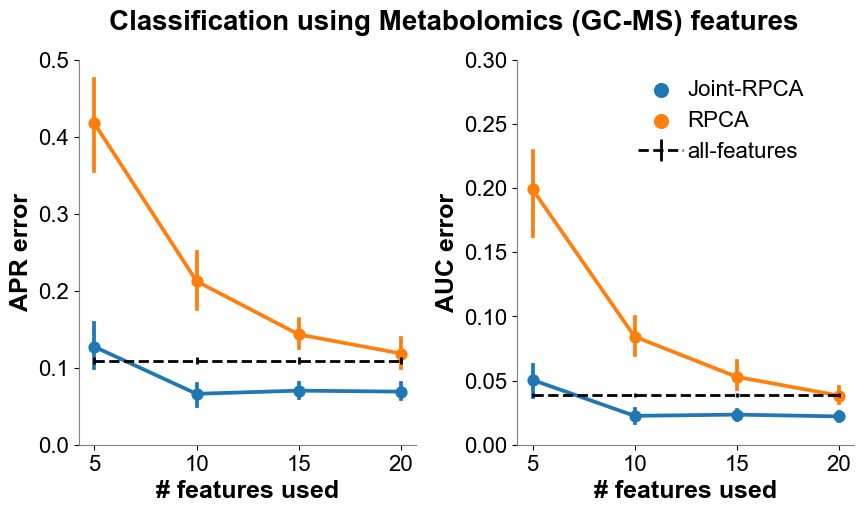

In [22]:
lims_ = {'gcms':[0.5,0.3]}

label_ = {'gcms':'Metabolomics (GC-MS)'}

for modality_name, modality_df in all_scores_sumamry_df.groupby('modality'):

    all_scores_sumamry_df_plt = modality_df.copy()
    all_scores_sumamry_df_plt['APR'] = 1 - all_scores_sumamry_df_plt['APR']
    all_scores_sumamry_df_plt['AUC'] = 1 - all_scores_sumamry_df_plt['AUC']

    fig, axn = plt.subplots(1,2,figsize=(10, 5))

    sns.pointplot(x='n_feats', y='APR', hue='selection', data=all_scores_sumamry_df_plt, ax=axn[0])
    x_ticks_ = axn[0].get_xticks()
    mean_ = [1 - np.mean(apr_all[modality_name])] * len(x_ticks_)
    std_ = [np.std(apr_all[modality_name])/len(apr_all[modality_name])] * len(x_ticks_)
    axn[0].errorbar(x_ticks_, mean_, yerr=std_, label='all-features', color='black', lw=2, ls='--')
    axn[0].legend_.remove()
    axn[0].set_ylim(0, lims_[modality_name][0])
    axn[0].set_ylabel('APR error', color='black', weight='bold',
                      fontsize=18, fontname='Arial')
    
    sns.pointplot(x='n_feats', y='AUC', hue='selection', data=all_scores_sumamry_df_plt, ax=axn[1])
    x_ticks_ = axn[1].get_xticks()
    mean_ = [1 - np.mean(roc_all[modality_name])] * len(x_ticks_)
    std_ = [np.std(roc_all[modality_name])/len(roc_all[modality_name])] * len(x_ticks_)
    axn[1].errorbar(x_ticks_, mean_, yerr=std_, label='all-features', color='black', lw=2, ls='--')
    axn[1].set_ylim(0, lims_[modality_name][1])
    axn[1].set_ylabel('AUC error', color='black', weight='bold',
                      fontsize=18, fontname='Arial')
        
    for ax in axn:
        ax.set_xlabel('# features used', color='black', weight='bold',
                      fontsize=18, fontname='Arial')
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(16)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_color("black")
            tick.set_fontsize(16)
        
    legend = ax.legend(loc=2, 
               bbox_to_anchor=(0.3, 1),
               prop={'size':16, 'family':'Arial'},
               title="", fancybox=True, framealpha=.0,
               handletextpad=0.2, ncol=1, markerscale=1.3)
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)

    plt.subplots_adjust(wspace=0.3)
    
    plt.suptitle("Classification using %s features" %label_[modality_name], 
                 color='black', weight='bold',
                 fontsize=20, fontname='Arial')
    plt.savefig('../../results/figure-5F.pdf',
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../../results/figure-5F.png',
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_65767/3583347979.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


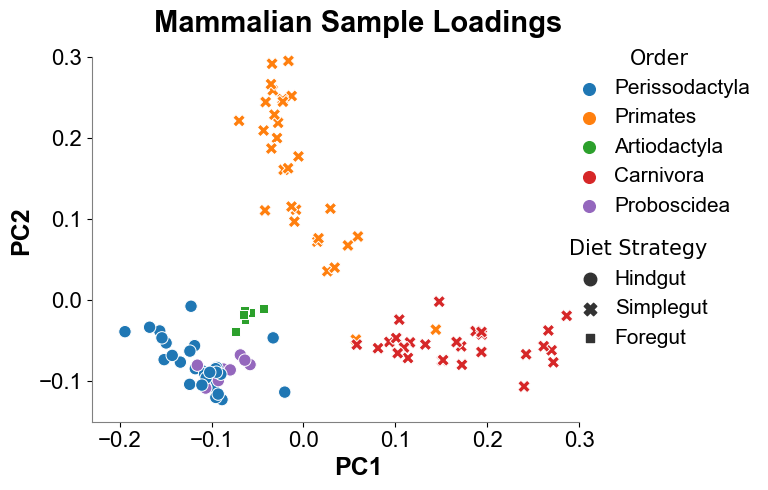

In [16]:
#update names based on feedback
metadata['KT_lineage'] = metadata.KT_lineage.str.replace('Afrotheria', 'Proboscidea')
metadata['KT_lineage'] = metadata.KT_lineage.str.replace('Cetartiodactyla', 'Artiodactyla')

i=6

ord_plt = pd.concat([joint_ords[str(i)].samples, metadata], axis=1)

fig, ax = plt.subplots(1,1,figsize=(8, 5), constrained_layout=True)

sns.scatterplot(x=0, y=1, hue='KT_lineage', style='digestive_strategy', s=80, data=ord_plt)

ax.set_xlabel('PC1', color='black', weight='bold',
              fontsize=18, fontname='Arial')
ax.set_ylabel('PC2', color='black', weight='bold',
              fontsize=18, fontname='Arial')
ax.set_title('Mammalian Sample Loadings', 
             color='black', weight='bold',
             fontsize=21, fontname='Arial')

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(16)

handles, labels = ax.get_legend_handles_labels()
num_hue = ord_plt['KT_lineage'].nunique()

# Add second legend for style
legend2 = ax.legend(
    handles[7:],
    labels[7:],
    title='Diet Strategy', loc='upper right',
    fancybox=True, framealpha=.0,
    ncol=1, markerscale=1.5,
    borderaxespad=0,
    handletextpad=0.2,     # space between marker and text
    labelspacing=0.5,      # space between entries
    bbox_to_anchor=(1.17, 0.5),
    prop={'size':15, 'family':'Arial'})
legend2.get_title().set_fontsize('15')
legend2._legend_box.align = "center"

# Recreate the legend with custom titles
legend1 = ax.legend(
    handles[1:6], labels[1:6],
    title='Order', loc='upper right',
    fancybox=True, framealpha=.0,
    ncol=1, markerscale=1.4,
    borderaxespad=0,
    handletextpad=0.2,     # space between marker and text
    labelspacing=0.5,      # space between entries
    bbox_to_anchor=(1.25, 1),
    prop={'size':15, 'family':'Arial'})
legend1.get_title().set_fontsize('15')
legend1._legend_box.align = "center"

ax.add_artist(legend2)

ax.set_ylim(-0.15, 0.32)
ax.set_xlim(-0.23, 0.35)
ax.spines['left'].set_bounds(-0.15, 0.3)
ax.spines['bottom'].set_bounds(-0.23, 0.3)

plt.tight_layout()

plt.savefig('../../results/figure-5D.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-5D.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()